In [1]:
# imports and settings
from pandas import DataFrame, melt
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from ipywidgets import FloatSlider, interactive

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

# Check if CUDA (GPU support) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# plot settings
sns.set_style('darkgrid')
plt.rcParams['figure.dpi'] = 100

# Building a binary classification model in Pytorch

This is a condensed version of the notebook from class when we discussed Logistic Regression.  You can use it as a template to build a nonlinear NN classifier for spiral data in Assignment 6.

**One New Feature:** We've added support for GPU's in this version of the notebook.  It certainly isn't necessary for the simple model we train here, but it will be useful later.


## Step 0 - Prepare the data.

For this example we'll use `make_blobs` from the `sklearn` package to generate two slightly overlapping groups of points:  

  

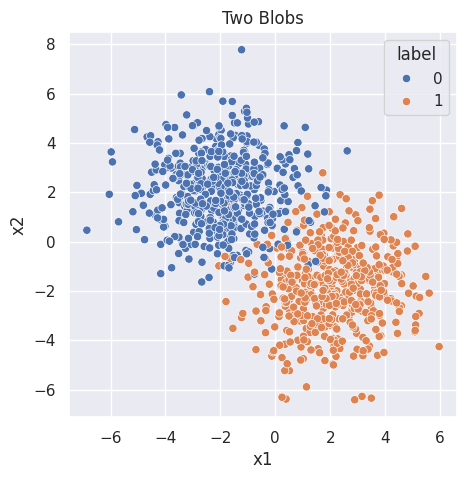

In [22]:
# generate 2d classification dataset
ctrs = [[-2,2],[2,-2]]
std = 1.5
X, y = make_blobs(n_samples=1000, centers=ctrs,
                  cluster_std = std, n_features=2,
                  random_state = 42)

# scatter plot, dots colored by class value
df = DataFrame({'x1':X[:,0], 'x2':X[:,1], 'label':y})
fig, axes = plt.subplots( figsize = (5,5) )
sns.scatterplot( ax = axes, data = df, x = 'x1', y = 'x2', hue = 'label');
axes.set_title('Two Blobs');


Now we'll split the data into training and validation sets using `train_test_split` from `sklearn` which randomly splits our sample into two datasets.  A typical split is to put 80% of the sample into the training set and 20% into the validation set

In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,
                                                      random_state=42)

Optionally, we can visualize the split data:

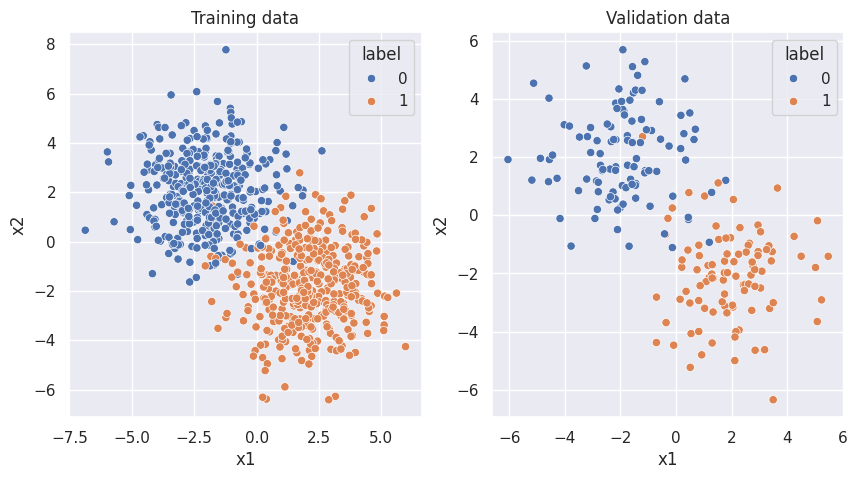

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

df_train = DataFrame({'x1':X_train[:,0], 'x2':X_train[:,1], 'label':y_train})
df_valid = DataFrame({'x1':X_valid[:,0], 'x2':X_valid[:,1], 'label':y_valid})

axes[0].set_title('Training data')
axes[1].set_title('Validation data')

sns.scatterplot( ax = axes[0], data = df_train, x = 'x1', y = 'x2', hue = 'label');
sns.scatterplot( ax = axes[1], data = df_valid, x = 'x1', y = 'x2', hue = 'label');

## Step 1 - Define the model in PyTorch.

The NN model we want to implement looks like this:

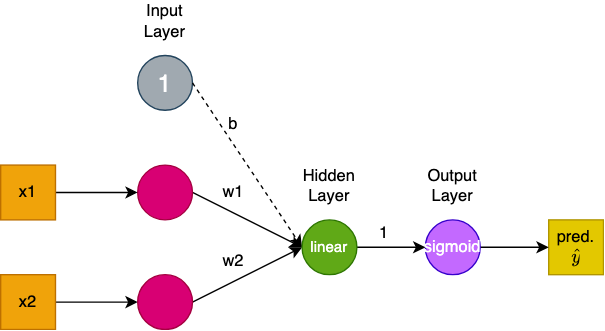

We can define it in a way that we can handle any number of inputs:

In [25]:
class LogisticRegression(nn.Module):
    '''
    Logistic Regression: 1 hidden layer with a single neuron
    and a sigmoid activation function
    '''
    def __init__(self, nInputs):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(nInputs, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return(self.layers(x))

Let's instantiate it and see if looks correct:

In [26]:
nInputs = 2
model = LogisticRegression(nInputs).to(device)
model

LogisticRegression(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

It looks good.  Note that our neural network will expect a 1D tensor of length 2 as an input and will output a 1D tensor of length 1.  Therefore the targets for our training will need to be 1D tensors of length 1.  

It's a good idea to check that model works as expected for its inputs and outputs.  You can create a random input, run the model to create an output, and check that at least the dimensions and shapes of the input and output tensors are correct:

In [27]:
input = torch.rand(2).to(device)
print('Model input: ', input, 'shape: ', input.shape, '\n')

output = model(input)
print('Model output: ', output, 'shape: ', output.shape, '\n')

Model input:  tensor([0.9714, 0.1629], device='cuda:0') shape:  torch.Size([2]) 

Model output:  tensor([0.2613], device='cuda:0', grad_fn=<SigmoidBackward0>) shape:  torch.Size([1]) 



Thus, the dataloader for this data will need to output tensors with those same shapes.

## Step 2 - Datasets and Dataloaders

We'll pass the numpy arrays into our Dataset where the conversion to tensors will be handled when we instantiate it.  For details, see the Logistic Regression notebook from class.

In [28]:
class RegressionData(Dataset):
    '''
    Custom 'Dataset' object for our regression data.
    Must implement these functions: __init__, __len__, and __getitem__.
    '''

    def __init__(self, X, y):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float().unsqueeze(-1)

    def __len__(self):
        return(len(self.X))

    def __getitem__(self, idx):
        return(self.X[idx], self.y[idx])

# instantiate Dataset object for current training data
dset_train = RegressionData(X_train, y_train)
dset_valid = RegressionData(X_valid, y_valid)

It's a good idea to check that your Dataset and Dataloader work as expected.  You can use the next cell to load a small batch for inspection.

In [29]:
# instantiate DataLoader
train_dataloader = DataLoader(dset_train, batch_size=4 , shuffle=True)
inputs, targets = next(iter(train_dataloader))
print(inputs)
print(inputs.shape)
print(targets)
print(targets.shape)

tensor([[ 4.3132,  1.0091],
        [-3.6014,  1.7864],
        [-1.7491,  1.4364],
        [-2.5037,  4.5035]])
torch.Size([4, 2])
tensor([[1.],
        [0.],
        [1.],
        [0.]])
torch.Size([4, 1])


## Step 3 - Train the model



In [30]:
##################################################
## training the model
##################################################

epochs = 20
outputInterval = 1
learningRate = 0.1
batchSize = 100
nInput = 2

# Create a new instance of the model to randomize the weights each time
torch.manual_seed(40)
model = LogisticRegression(nInput).to(device)

# Make new instance of dataloader with batchSize
train_dataloader = DataLoader(dset_train, batch_size=batchSize, shuffle=True)
valid_dataloader = DataLoader(dset_valid, batch_size=batchSize, shuffle=False)

# Define the loss function and optimizer
loss_function = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

# Initialize lists to losses for later plotting
loss_train_list = []
loss_valid_list = []

# Run the training loop
for epoch in range(epochs):

    # Training Phase
    model.train()
    loss_train = 0.0
    correct_train = 0
    num_train = 0

    for inputs, targets in train_dataloader:

        # Move inputs and targets to the device
        inputs, targets = inputs.to(device), targets.to(device)

        # one training step
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

        # accumulate accuracy and loss
        loss_train += loss.item()
        prediction = torch.round(outputs.detach())
        correct_train += (prediction == targets).sum().item()
        num_train += len(outputs)

    acc_train = 100 * correct_train / num_train
    loss_train = loss_train / num_train
    loss_train_list.append(loss_train)

    # Validation phase
    model.eval()
    loss_valid = 0.0
    correct_valid = 0
    num_valid = 0

    with torch.no_grad():
        for inputs, targets in valid_dataloader:

            # Move inputs and targets to the device
            inputs, targets = inputs.to(device), targets.to(device)

            # predictions and loss
            outputs = model(inputs)
            loss = loss_function(outputs, targets)

            # accumulate accuracy and loss
            loss_valid += loss.item()
            prediction = torch.round(outputs)
            correct_valid += (prediction == targets).sum().item()
            num_valid += len(outputs)

    acc_valid = 100 * correct_valid / num_valid
    loss_valid = loss_valid / num_valid
    loss_valid_list.append(loss_valid)

    if (epoch + 1) % outputInterval == 0:
        print( (f'At epoch {epoch+1} '
                f'train_loss = {loss_train:.3e}, '
                f'val_loss = {loss_valid:.3e}, '
                f'acc_train = {acc_train:.2f}% '
                f'acc_valid = {acc_valid:.2f}%' ) )


At epoch 1 train_loss = 7.199e-03, val_loss = 2.789e-03, acc_train = 61.38% acc_valid = 95.00%
At epoch 2 train_loss = 2.220e-03, val_loss = 1.849e-03, acc_train = 95.25% acc_valid = 95.00%
At epoch 3 train_loss = 1.626e-03, val_loss = 1.541e-03, acc_train = 96.50% acc_valid = 94.50%
At epoch 4 train_loss = 1.377e-03, val_loss = 1.391e-03, acc_train = 96.88% acc_valid = 94.50%
At epoch 5 train_loss = 1.235e-03, val_loss = 1.303e-03, acc_train = 97.12% acc_valid = 94.50%
At epoch 6 train_loss = 1.142e-03, val_loss = 1.248e-03, acc_train = 97.12% acc_valid = 94.50%
At epoch 7 train_loss = 1.077e-03, val_loss = 1.210e-03, acc_train = 97.00% acc_valid = 94.50%
At epoch 8 train_loss = 1.026e-03, val_loss = 1.183e-03, acc_train = 97.12% acc_valid = 94.50%
At epoch 9 train_loss = 9.876e-04, val_loss = 1.164e-03, acc_train = 97.12% acc_valid = 94.50%
At epoch 10 train_loss = 9.563e-04, val_loss = 1.149e-03, acc_train = 97.25% acc_valid = 94.50%
At epoch 11 train_loss = 9.301e-04, val_loss = 1.

It's a good idea to plot the training and validation loss to see if the training is effective and if there is overfitting (more about this soon).

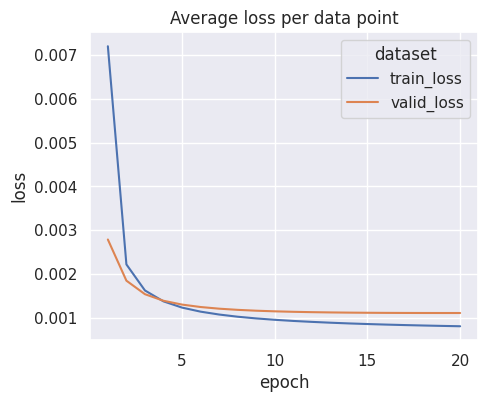

In [31]:
def plot_losses(train_loss, valid_loss):
  train_loss = np.array(train_loss)
  valid_loss = np.array(valid_loss)
  epoch = np.arange(1,len(train_loss)+1)
  data_wide = DataFrame({'epoch':epoch,'train_loss':train_loss,'valid_loss':valid_loss})
  data_long = melt(data_wide, ['epoch'], var_name = 'dataset', value_name = 'loss')
  fig,axis = plt.subplots( figsize = (5,4) )
  sns.lineplot( ax = axis, data = data_long, x = 'epoch', y = 'loss', hue = 'dataset')
  axis.set_title('Average loss per data point')

plot_losses(loss_train_list, loss_valid_list)

## Step 4 - Visualize the results

The function `classify_2D_plot` below will help to visualize the results including the model and decision boundary.  It's only intended to work with a PyTorch model that takes two inputs and whose output is in [0,1].  Don't worry about the details of this function, but you can use it in your homework.

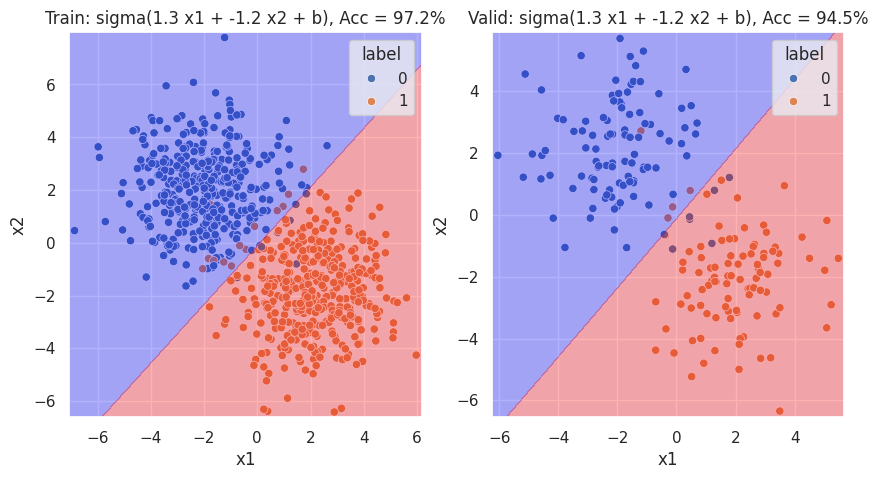

In [32]:
def classify_2D_plot(ax, pretitle_str, dataset, *model, num_contours = 1, npts = 10):

    x1 = dataset.X[:,0].squeeze().numpy()
    x2 = dataset.X[:,1].squeeze().numpy()

    pad_scale = 0.2
    x1min, x1max = np.min(x1), np.max(x1)
    x1pad = pad_scale*(x1max-x1min)
    x1min, x1max = x1min - pad_scale, x1max + pad_scale
    x2min, x2max = np.min(x2), np.max(x2)
    x2pad = pad_scale*(x2max-x2min)
    x2min, x2max = x2min - pad_scale, x2max + pad_scale
    labels_np = dataset.y.squeeze().numpy().astype(int)
    labels_torch = dataset.y.int()

    # scatter plot, dots colored by class value
    df = DataFrame(dict(x1=x1, x2=x2, label=labels_np))
    sns.scatterplot( ax = ax, x = 'x1', y = 'x2', data = df,
                  hue = 'label').set(title=pretitle_str);
    ax.set_xlim(x1min,x1max)
    ax.set_ylim(x2min,x2max)

    if len(model) > 0:
        model = model[0]
        # extract the parameters
        params = [ p.cpu().detach().numpy() for p in model.parameters()]
        w1 = params[0][0,0]
        w2 = params[0][0,1]
        b = params[1][0]
        slope = -w1/w2
        intercept = -b/w2

        # compute the accuracy on the data
        yhat = model(dataset.X.to(device)).cpu()
        pred = (yhat >= 0.5).int()
        accuracy = 100*torch.sum(pred==labels_torch)/len(labels_torch)
        title_str = f'{pretitle_str}: sigma({w1:.1f} x1 + {w2:.1f} x2 + b), Acc = {accuracy:.1f}%'

        # plot the decision boundary and the fills
        x1_ls = torch.linspace(x1min,x1max,npts).float()
        x2_ls = torch.linspace(x2min,x2max,npts).float()
        x1_mg, x2_mg = torch.meshgrid( x1_ls, x2_ls )
        grid = torch.stack( (x1_mg.flatten(), x2_mg.flatten() ), dim = 1)
        grid = grid.to(device)
        with torch.no_grad():
            z = model(grid).reshape(npts,npts).cpu()
        ax.contourf(x1_mg.numpy(), x2_mg.numpy(), z.numpy(), 1, alpha = 0.3, cmap = 'seismic')
        ax.set_title(title_str)


fig, axes = plt.subplots(1, 2, figsize=(10,5))
classify_2D_plot(axes[0],'Train',dset_train,model,npts=20)
classify_2D_plot(axes[1],'Valid',dset_valid,model)